In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow_addons as tfa
from skimage import exposure


warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [2]:
path = '/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive' #get dir path

#print out images num from each of the 5 class
for i in range(5): 
  folder_path = path+'/'+str(i)
  num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
  print(num_files)

25810
2443
5292
873
708


In [11]:

os.chdir("./")

if os.path.isdir("train/0") is False:
    print("xxxxx")
    
    os.mkdir("./train") # create train folders
    os.mkdir("./test")  # create test folders 
    os.mkdir("./valid") # create valid folders 
    
    # form train, test, and valid data folders
    for i in range(0, 5):
        # initialize folder paths
        numOfFold = f'{path}/{i}' 
        num_files_in_folder = len(os.listdir(numOfFold))

        train_size = 700
        test_size = 700
        valid_size = 700
        
        # make classes within set
        
        os.mkdir(f'train/{i}')
        os.mkdir(f'test/{i}')
        os.mkdir(f'valid/{i}')

        train_samples = random.sample(os.listdir(numOfFold), train_size)
        for file_name in train_samples:
            shutil.copy((f"../archive/{i}/{file_name}"), f'./train/{i}')

        test_samples = random.sample(os.listdir(numOfFold), test_size)
        for file_name in test_samples:
            shutil.copy((f"../archive/{i}/{file_name}"), f'./test/{i}')  
            
        valid_samples = random.sample(os.listdir(numOfFold), valid_size)
        for file_name in valid_samples:
            shutil.copy((f"../archive/{i}/{file_name}"), f'./valid/{i}')
        

xxxxx
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/0
25810
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/1
2443
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/2
5292
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/3
873
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/4
708


In [12]:
# train,test, and valid 
TRAIN_PATH = "./train"
TEST_PATH = "./test"
VALID_PATH = "./valid"

In [ ]:
# preprocessing the image before loading to dataloader
def preprocesser(image):
    # adjust contrast
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    # image = exposure.adjust_gamma(image, 2)
    # transform images from rgb to grayscale
    image = tf.image.rgb_to_grayscale(image)
    return image

In [ ]:
# PARAMETERS SETTING
PREPROCESSING_FUNC = preprocesser
CLASS_MODE = "categorical"
BATCH_SIZE = 32
TARGET_SIZE = (224,224)

# SHOULD HAVE 3500=700*5 IN TOTAL 
train_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255, horizontal_flip=True).flow_from_directory(directory = TRAIN_PATH, target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode=CLASS_MODE)
test_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255).flow_from_directory(directory = TEST_PATH, target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255).flow_from_directory(directory = VALID_PATH, target_size = TARGET_SIZE, batch_size = BATCH_SIZE, shuffle = False, class_mode=CLASS_MODE)

In [24]:
# PARAMETERS FOR MODEL
NUM_EPOCH = 50
LEARNING_RATE = 0.001
LOSS_FUNC = "categorical_crossentropy"
TRAIL_NUM = 1
# SECOND_PASS = False 
PATIENCE = 25



In [25]:
#MODEL LOADING
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
model.summary() #glance at model summary

                   
 block_8_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_8_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_8_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_8_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   
                                                                                                  
 block_8_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_8_depthwise_relu[0][0]'] 
                                                                                         

In [26]:
for layer in model.layers: # originally 23
    layer.trainable = SECOND_PASS

In [28]:
# adding new output layer to MobileNetV2, specific to our problem
x = Flatten()(model.output)
output = Dense(units=5, activation="softmax")(x) # 5 units for, 1 for each class

In [29]:
model = Model(inputs = model.input, outputs = output)

In [30]:
model.summary() #show model summary

wise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   
                                                                                                  
 block_8_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_8_depthwise_relu[0][0]'] 
                                                                                                  
 block_8_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_8_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_8_add (Add)              (None, 14, 14, 64)   0           ['block_7_add[0][0]',    

In [31]:
# number of training params in MobileNetV2 model with new output layer
trainable_params_freeze = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
non_trainable_params_freeze = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
print(f"trainable params: {trainable_params_freeze}\n non trainable params: {non_trainable_params_freeze}")

trainable params: 313605
non trainable params: 2257984


In [32]:
# define model with loss function and optimizer
model.compile(optimizer=Adam(lr=LEARNING_RATE), loss=LOSS_FUNC, metrics=["accuracy"])

In [36]:
# training
model.fit_generator(train_batches, validation_data=valid_batches, epochs=NUM_EPOCH, verbose=2, callbacks=EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True))

Epoch 1/50
110/110 - 398s - loss: 6.2140 - accuracy: 0.3357 - val_loss: 4.2937 - val_accuracy: 0.4243 - 398s/epoch - 4s/step
Epoch 2/50
110/110 - 348s - loss: 3.8693 - accuracy: 0.4711 - val_loss: 6.5435 - val_accuracy: 0.4537 - 348s/epoch - 3s/step
Epoch 3/50
110/110 - 271s - loss: 3.5436 - accuracy: 0.5446 - val_loss: 4.3384 - val_accuracy: 0.4911 - 271s/epoch - 2s/step
Epoch 4/50
110/110 - 316s - loss: 3.1919 - accuracy: 0.6009 - val_loss: 4.3395 - val_accuracy: 0.5149 - 316s/epoch - 3s/step
Epoch 5/50
110/110 - 369s - loss: 2.3481 - accuracy: 0.6740 - val_loss: 4.2011 - val_accuracy: 0.4909 - 369s/epoch - 3s/step
Epoch 6/50
110/110 - 327s - loss: 2.2456 - accuracy: 0.6929 - val_loss: 4.8084 - val_accuracy: 0.5314 - 327s/epoch - 3s/step
Epoch 7/50
110/110 - 444s - loss: 1.9177 - accuracy: 0.7351 - val_loss: 4.1222 - val_accuracy: 0.5471 - 444s/epoch - 4s/step
Epoch 8/50
110/110 - 315s - loss: 1.3282 - accuracy: 0.7829 - val_loss: 4.9259 - val_accuracy: 0.5720 - 315s/epoch - 3s/step


In [37]:
SAVE_LOC = f'./trial{TRAIL_NUM}' 

In [38]:
model.save(SAVE_LOC, save_format="h5") #save model

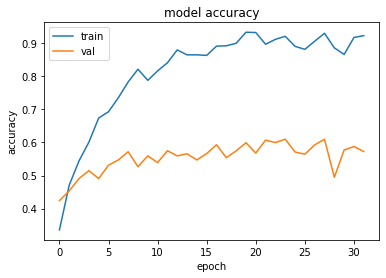

In [39]:
# plot model accuracy (training + valid)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

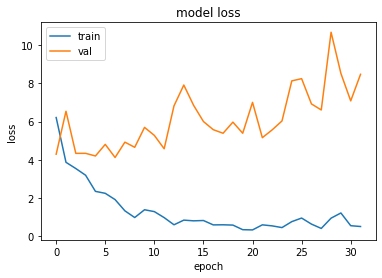

In [42]:
# plot model loss (training + valid)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()